Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time
from datetime import timedelta
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from scipy.spatial import distance
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large\\A', 'notMNIST_large\\B', 'notMNIST_large\\C', 'notMNIST_large\\D', 'notMNIST_large\\E', 'notMNIST_large\\F', 'notMNIST_large\\G', 'notMNIST_large\\H', 'notMNIST_large\\I', 'notMNIST_large\\J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small\\A', 'notMNIST_small\\B', 'notMNIST_small\\C', 'notMNIST_small\\D', 'notMNIST_small\\E', 'notMNIST_small\\F', 'notMNIST_small\\G', 'notMNIST_small\\H', 'notMNIST_small\\I', 'notMNIST_small\\J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [4]:
from IPython.display import Image, display

num_first_items = 1
def display_first_items(folder_path): 
    print('Letter:', folder_path[-1:])
    lst = os.listdir(folder_path)[:num_first_items]
    for file_name in lst: 
        full_file_name = os.path.join(folder_path, file_name)
        display(Image(filename=full_file_name))

for folder in train_folders:
    display_first_items(folder)
for folder in test_folders:
    display_first_items(folder)


Letter: A


Letter: B


Letter: C


Letter: D


Letter: E


Letter: F


Letter: G


Letter: H


Letter: I


Letter: J


Letter: A


Letter: B


Letter: C


Letter: D


Letter: E


Letter: F


Letter: G


Letter: H


Letter: I


Letter: J


Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [5]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      if image_data.mean() == 0.5:
        print('No data in image:', image_file)
        continue
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1600)

notMNIST_large\A.pickle already present - Skipping pickling.
notMNIST_large\B.pickle already present - Skipping pickling.
notMNIST_large\C.pickle already present - Skipping pickling.
notMNIST_large\D.pickle already present - Skipping pickling.
notMNIST_large\E.pickle already present - Skipping pickling.
notMNIST_large\F.pickle already present - Skipping pickling.
notMNIST_large\G.pickle already present - Skipping pickling.
notMNIST_large\H.pickle already present - Skipping pickling.
notMNIST_large\I.pickle already present - Skipping pickling.
notMNIST_large\J.pickle already present - Skipping pickling.
notMNIST_small\A.pickle already present - Skipping pickling.
notMNIST_small\B.pickle already present - Skipping pickling.
notMNIST_small\C.pickle already present - Skipping pickling.
notMNIST_small\D.pickle already present - Skipping pickling.
notMNIST_small\E.pickle already present - Skipping pickling.
notMNIST_small\F.pickle already present - Skipping pickling.
notMNIST_small\G.pickle 

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

notMNIST_large\A.pickle


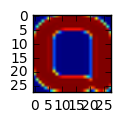

notMNIST_large\B.pickle


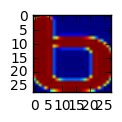

notMNIST_large\C.pickle


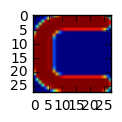

notMNIST_large\D.pickle


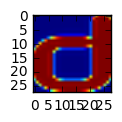

notMNIST_large\E.pickle


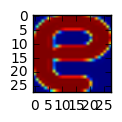

notMNIST_large\F.pickle


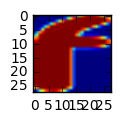

notMNIST_large\G.pickle


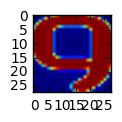

notMNIST_large\H.pickle


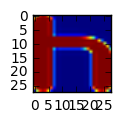

notMNIST_large\I.pickle


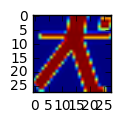

notMNIST_large\J.pickle


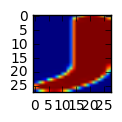

notMNIST_small\A.pickle


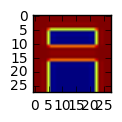

notMNIST_small\B.pickle


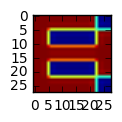

notMNIST_small\C.pickle


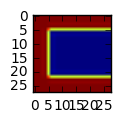

notMNIST_small\D.pickle


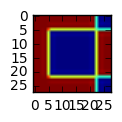

notMNIST_small\E.pickle


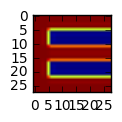

notMNIST_small\F.pickle


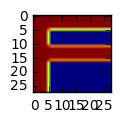

notMNIST_small\G.pickle


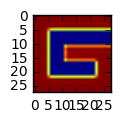

notMNIST_small\H.pickle


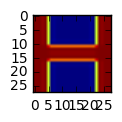

notMNIST_small\I.pickle


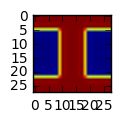

notMNIST_small\J.pickle


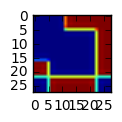

In [6]:
def show_pickle(file_path):
    print(file_path)
    with open(file_path, 'rb') as f:
        dataset = pickle.load(f)
    plt.figure(figsize=(1,1))
    plt.imshow(dataset[1])
    plt.show()
        
for pickle_file in train_datasets:
    show_pickle(pickle_file)
for pickle_file in test_datasets:
    show_pickle(pickle_file)
    

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [25]:
map_dict = {'0': 'A', '1': 'B', '2': 'C', '3': 'D', '4': 'E', '5': 'F', '6': 'G', '7': 'H', '8': 'I', '9': 'J', }

def get_char_by_lbl(lbl):
    result = map_dict[str(lbl)]
    return result

def count_lables(label_list):
    counter_dict = {}
    for label in label_list:
        lbl = get_char_by_lbl(label)
        if lbl not in counter_dict:
            counter_dict[lbl] = 0
        counter_dict[lbl] += 1
    return counter_dict

In [22]:
def show_pickle_stats(file_path):
    with open(file_path, 'rb') as f:
        dataset = pickle.load(f)
    print(file_path, len(dataset))

for pickle_file in train_datasets:
    show_pickle_stats(pickle_file)
for pickle_file in test_datasets:
    show_pickle_stats(pickle_file)

notMNIST_large\A.pickle 52904
notMNIST_large\B.pickle 52895
notMNIST_large\C.pickle 52894
notMNIST_large\D.pickle 52906
notMNIST_large\E.pickle 52902
notMNIST_large\F.pickle 52906
notMNIST_large\G.pickle 52893
notMNIST_large\H.pickle 52899
notMNIST_large\I.pickle 47469
notMNIST_large\J.pickle 52894
notMNIST_small\A.pickle 1872
notMNIST_small\B.pickle 1873
notMNIST_small\C.pickle 1873
notMNIST_small\D.pickle 1873
notMNIST_small\E.pickle 1873
notMNIST_small\F.pickle 1872
notMNIST_small\G.pickle 1872
notMNIST_small\H.pickle 1872
notMNIST_small\I.pickle 1618
notMNIST_small\J.pickle 1872


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [9]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [23]:
print('train labels:', count_lables(train_labels))
print('valid labels:', count_lables(valid_labels))
print('test labels:', count_lables(test_labels))

train labels: {'B': 20000, 'F': 20000, 'D': 20000, 'J': 20000, 'I': 20000, 'E': 20000, 'A': 20000, 'C': 20000, 'H': 20000, 'G': 20000}
valid labels: {'D': 1000, 'B': 1000, 'F': 1000, 'I': 1000, 'J': 1000, 'E': 1000, 'C': 1000, 'A': 1000, 'H': 1000, 'G': 1000}
test labels: {'B': 1000, 'F': 1000, 'D': 1000, 'J': 1000, 'E': 1000, 'C': 1000, 'G': 1000, 'A': 1000, 'H': 1000, 'I': 1000}


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [11]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

In [12]:
print('train labels:', count_lables(train_labels))
print('valid labels:', count_lables(valid_labels))
print('test labels:', count_lables(test_labels))

train labels: {'B': 20000, 'F': 20000, 'D': 20000, 'J': 20000, 'I': 20000, 'E': 20000, 'A': 20000, 'C': 20000, 'H': 20000, 'G': 20000}
valid labels: {'D': 1000, 'B': 1000, 'F': 1000, 'I': 1000, 'J': 1000, 'E': 1000, 'C': 1000, 'A': 1000, 'H': 1000, 'G': 1000}
test labels: {'B': 1000, 'F': 1000, 'D': 1000, 'J': 1000, 'E': 1000, 'C': 1000, 'G': 1000, 'A': 1000, 'H': 1000, 'I': 1000}


F


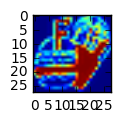

E


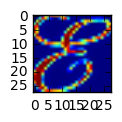

G


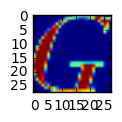

H


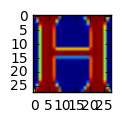

C


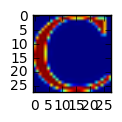

B


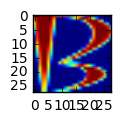

A


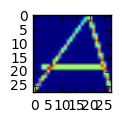

B


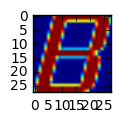

C


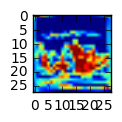

In [13]:
def show_data(dataset, labels, size=3):
    print('=============================================')
    for lbl, img_arr in zip(labels[:size], dataset[:size]):
        print(map_dict[str(lbl)])
        plt.figure(figsize=(1,1))
        plt.imshow(img_arr)
        plt.show()

show_data(train_dataset, train_labels)
show_data(test_dataset, test_labels)
show_data(valid_dataset, valid_labels)

Finally, let's save the data for later reuse:

In [14]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [15]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800503


In [4]:
bins_size = 28 * 4

def calc_histogram(dataset, bins = bins_size):
    start_time = time.clock()
    hist_list = []
    for item in dataset:
        hist = np.histogram(item, bins=bins)
        hist_list.append(hist[0])
    end_time = time.clock()
    return (hist_list, timedelta(seconds=end_time - start_time))

In [120]:
train_histogram, calc_duration = calc_histogram(train_dataset, bins_size)
print('Histograms for train dataset calculates in', calc_duration)
valid_histogram, calc_duration = calc_histogram(valid_dataset, bins_size)
print('Histograms for validation dataset calculates in', calc_duration)
test_histogram, calc_duration = calc_histogram(test_dataset, bins_size)
print('Histograms for test dataset calculates in', calc_duration)

Histograms for train dataset calculates in 0:00:22.258678
Histograms for validation dataset calculates in 0:00:01.116859
Histograms for test dataset calculates in 0:00:01.116659


In [121]:
pickle_hist_file = 'notMNIST.hist.pickle'

try:
  f = open(pickle_hist_file, 'wb')
  save = {
    'train_histogram': train_histogram,
    'valid_histogram': valid_histogram,
    'test_histogram': test_histogram,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_hist_file, ':', e)
  raise
statinfo = os.stat(pickle_hist_file)
print('Compressed histograms pickle size:', statinfo.st_size)

Compressed histograms pickle size: 204408510


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [2]:
pickle_file = 'notMNIST.pickle'
pickle_hist_file = 'notMNIST.hist.pickle'
try:
    with open(pickle_file, 'rb') as f:
        save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    print('Training:', train_dataset.shape, train_labels.shape)
    print('Validation:', valid_dataset.shape, valid_labels.shape)
    print('Testing:', test_dataset.shape, test_labels.shape)
except Exception as e:
  print('Unable to load full dataset to', pickle_file, ':', e)
  raise

try:
    with open(pickle_hist_file, 'rb') as f:
        save = pickle.load(f)
    train_histogram = save['train_histogram']
    valid_histogram = save['valid_histogram']
    test_histogram = save['test_histogram']
    print('Training histogram:', len(train_histogram))
    print('Validation histogram:', len(valid_histogram))
    print('Testing histogram:', len(test_histogram))
except Exception as e:
  print('Unable to load full dataset to', pickle_file, ':', e)
  raise

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)
Training histogram: 200000
Validation histogram: 10000
Testing histogram: 10000


In [50]:
x = np.array(range(bins_size))

def draw_images(label, a_arr, b_arr):
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(8, 1))
    h_a = np.histogram(a_arr, bins=bins_size)
    h_b = np.histogram(b_arr, bins=bins_size)
    ax1.imshow(a_arr)
    ax1.set_title('Label: ' + label)
    ax2.bar(x, h_a[0])
    ax3.imshow(b_arr)
    ax4.bar(x, h_b[0])
    plt.show()
            
def is_equal_comparison(a_arr, b_arr):
    return (a_arr==b_arr).all()

def euclidean_distance(a_arr, b_arr): 
    '''Euclidean distance without the sqrt'''
    return np.sum(np.power(a_arr - b_arr, 2))

def manhattan_distance(a_arr, b_arr):
    return np.sum(np.absolute(a_arr - b_arr))

def count_duplication(counters, lbl, idxA, idxB):
    str_lbl = get_char_by_lbl(lbl)
    if str_lbl not in counters:
        counters[str_lbl] = {}
        counters[str_lbl]['counter'] = 0
    counters[str_lbl]['counter'] += 1
    if str(idxA) not in counters[str_lbl]:
        counters[str_lbl][str(idxA)] = []
    counters[str_lbl][str(idxA)].append(idxB)

def count_equal_hist(label_lst_A, hist_lst_A, label_lst_B, hist_lst_B, distance_threshold=0):
    start_time = time.clock()
    counters = {}
    for idxA, lblA in enumerate(label_lst_A):
        for idxB, lblB in enumerate(label_lst_B):
            if lblA == lblB:
                histA = hist_lst_A[idxA]
                histB = hist_lst_B[idxB]
                if distance_threshold == 0 and is_equal_comparison(histA, histB):
                    count_duplication(counters, lblA, idxA, idxB)
                if distance_threshold > 0 and distance_threshold >= manhattan_distance(histA, histB) > 0:
                    count_duplication(counters, lblA, idxA, idxB)
    end_time = time.clock()
    return (counters, timedelta(seconds=end_time - start_time))

def display_overlap(counters):
    key_lst = sorted(counters.keys())
    total = 0
    for key in key_lst:
        total += counters[key]['counter']
        print('Label {0}: {1}'.format(key, counters[key]['counter']))
    print('Total:', total)


In [116]:
distance_overlapping = 50

In [107]:
overlap_train_valid, count_duration = count_equal_data(train_labels, train_histogram,
                                                        valid_labels, valid_histogram)
print('Overlapping between train and validation datasets counted in', count_duration)
display_overlap(overlap_train_valid)

Overlapping between train and validation datasets counted in 0:18:14.342132
Label A: 94
Label B: 146
Label C: 110
Label D: 97
Label E: 129
Label F: 126
Label G: 101
Label H: 154
Label I: 1302
Label J: 122
Total: 2381


In [108]:
overlap_train_valid_distance, count_duration = count_equal_data(train_labels, train_histogram,
                                                                valid_labels, valid_histogram,
                                                                distance_overlapping)
print('Overlapping between train and validation datasets (with distance) counted in', count_duration)
display_overlap(overlap_train_valid_distance)

Overlapping between train and validation datasets (with distance) counted in 0:25:24.847459
Label A: 20
Label B: 28
Label C: 14
Label D: 17
Label E: 23
Label F: 30
Label G: 11
Label H: 62
Label I: 964
Label J: 26
Total: 1195


In [109]:
overlap_train_test, count_duration = count_equal_data(train_labels, train_histogram,
                                                        test_labels, test_histogram)
print('Overlapping between train and validation datasets counted in', count_duration)
display_overlap(overlap_train_test)

Overlapping between train and validation datasets counted in 0:18:24.155693
Label A: 134
Label B: 137
Label C: 145
Label D: 113
Label E: 119
Label F: 165
Label G: 137
Label H: 182
Label I: 1347
Label J: 125
Total: 2604


In [110]:
overlap_train_test_distance, count_duration = count_equal_data(train_labels, train_histogram,
                                                        test_labels, valid_histogram,
                                                           distance_overlapping)
print('Overlapping between train and validation datasets (with distance) counted in', count_duration)
display_overlap(overlap_train_test_distance)

Overlapping between train and validation datasets (with distance) counted in 0:25:34.896381
Label A: 4
Label B: 3
Label C: 1
Label D: 3
Label E: 2
Label F: 5
Label G: 3
Label H: 16
Label I: 63
Label J: 2
Total: 102


In [111]:
overlap_valid_test, count_duration = count_equal_data(valid_labels, valid_histogram,
                                                        test_labels, test_histogram)
print('Counting overlapping between validation and test datasets in', count_duration)
display_overlap(overlap_valid_test)

Counting overlapping between validation and test datasets in 0:00:55.316327
Label A: 5
Label B: 7
Label C: 10
Label D: 9
Label E: 11
Label F: 3
Label G: 11
Label H: 6
Label I: 77
Label J: 8
Total: 147


In [112]:
overlap_valid_test_distance, count_duration = count_equal_data(valid_labels, valid_histogram,
                                                                test_labels, test_histogram,
                                                                distance_overlapping)
print('Counting overlapping between validation and test datasets (with distance) in', count_duration)
display_overlap(overlap_valid_test_distance)

Counting overlapping between validation and test datasets (with distance) in 0:01:16.646290
Label A: 1
Label D: 3
Label E: 3
Label H: 8
Label I: 36
Label J: 1
Total: 52


In [101]:
overlap_valid_test_distance

{'A': {'1713': [2391], 'counter': 1},
 'D': {'284': [9535], '8238': [3469], '9937': [7358], 'counter': 3},
 'E': {'1299': [2207], '3401': [5864], '9997': [9100], 'counter': 3},
 'H': {'1084': [9460],
  '3456': [6700],
  '3650': [7782],
  '8345': [2050],
  '8914': [3606],
  '9087': [6285],
  '959': [1793],
  '9893': [2429],
  'counter': 8},
 'I': {'1734': [7251, 8480],
  '195': [7251, 8480],
  '2171': [7251, 8480],
  '3841': [7251, 8441, 8480],
  '4787': [7251, 8480],
  '5624': [7251, 8480],
  '6448': [436, 5521, 5727],
  '6538': [1181, 2755, 5271, 5853, 7251, 8480, 9154],
  '7479': [1181, 2755, 5271, 5853, 7251, 8480, 9154],
  '8772': [7251, 8441, 8480],
  '9134': [8441],
  '9244': [9377],
  '9592': [8441],
  'counter': 36},
 'J': {'6999': [2894], 'counter': 1}}

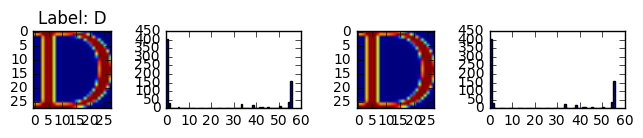

In [102]:
draw_images('D', valid_dataset[284], test_dataset[9535])

In [73]:
euclidean_distance(valid_dataset[8], test_dataset[3660])

228.68698

In [74]:
manhattan_distance(valid_dataset[8], test_dataset[3660])

272.42352

In [103]:
hist_A = np.histogram(valid_dataset[284], bins=bins_size)
hist_B = np.histogram(test_dataset[9535], bins=bins_size)

In [104]:
euclidean_distance(hist_A[0], hist_B[0])

8

In [105]:
manhattan_distance(hist_A[0], hist_B[0])

8

In [117]:
bins_list = [7, 28, 56, 112]
for bins_item in bins_list:
    valid_histogram, calc_duration = calc_histogram(valid_dataset, bins_item)
    print('Validation histograms for {0} bins. Time {1}'.format(bins_item, calc_duration))
    test_histogram, calc_duration = calc_histogram(test_dataset, bins_item)
    print('Test histograms for {0} bins. Time {1}'.format(bins_item, calc_duration))
    overlap_valid_test, count_duration = count_equal_data(valid_labels, valid_histogram,
                                                        test_labels, test_histogram)
    print('Counting overlapping between validation and test datasets in', count_duration)
    display_overlap(overlap_valid_test)
    overlap_valid_test_distance, count_duration = count_equal_data(valid_labels, valid_histogram,
                                                                test_labels, test_histogram,
                                                                distance_overlapping)
    print('Counting overlapping between validation and test datasets (with distance) in', count_duration)
    display_overlap(overlap_valid_test_distance)
    print('=============================================================================================')

Validation histograms for 7 bins. Time 0:00:01.115147
Test histograms for 7 bins. Time 0:00:01.113494
Counting overlapping between validation and test datasets in 0:00:53.366928
Label A: 5
Label B: 7
Label C: 10
Label D: 11
Label E: 11
Label F: 3
Label G: 11
Label H: 8
Label I: 203
Label J: 9
Total: 278
Counting overlapping between validation and test datasets (with distance) in 0:01:15.590197
Label A: 27543
Label B: 10299
Label C: 36819
Label D: 11587
Label E: 4554
Label F: 7473
Label G: 19705
Label H: 5974
Label I: 8273
Label J: 18535
Total: 150762
Validation histograms for 28 bins. Time 0:00:01.125957
Test histograms for 28 bins. Time 0:00:01.109607
Counting overlapping between validation and test datasets in 0:00:54.082757
Label A: 5
Label B: 7
Label C: 10
Label D: 9
Label E: 11
Label F: 3
Label G: 11
Label H: 6
Label I: 140
Label J: 9
Total: 211
Counting overlapping between validation and test datasets (with distance) in 0:01:14.840965
Label A: 49
Label B: 7
Label C: 130
Label D: 

In [108]:
idx_idx = 0
lbl_idx = 1
data_idx = 2

def count_equal_data(label_lst_A, data_lst_A, label_lst_B, data_lst_B, distance_threshold=0):
    start_time = time.clock()
    counters = {}
    for idxA, lblA in enumerate(label_lst_A):
        for idxB, lblB in enumerate(label_lst_B):
            if lblA == lblB:
                itemA = data_lst_A[idxA]
                itemB = data_lst_B[idxB]
                if distance_threshold == 0 and is_equal_comparison(itemA, itemB):
                    count_duplication(counters, lblA, idxA, idxB)
                if distance_threshold > 0 and distance_threshold >= manhattan_distance(itemA, itemB) > 0:
                    count_duplication(counters, lblA, idxA, idxB)
    end_time = time.clock()
    return (counters, timedelta(seconds=end_time - start_time))

def count_equal_tuples(tuple_lst_A, tuple_lst_B, distance_threshold=0, min_distance_threshold = 0):
    counters = {}
    for item_A in tuple_lst_A:
        for item_B in tuple_lst_B:
            if item_A[lbl_idx] == item_B[lbl_idx]:
                if distance_threshold == 0 and is_equal_comparison(item_A[data_idx], item_B[data_idx]):
                    count_duplication(counters, item_A[lbl_idx], item_A[idx_idx], item_B[idx_idx])
                if distance_threshold > 0 and distance_threshold >= manhattan_distance(item_A[data_idx], item_B[data_idx]) > min_distance_threshold:
                    count_duplication(counters, item_A[lbl_idx], item_A[idx_idx], item_B[idx_idx])
    return counters

In [91]:
def wrap_tuples(labels, dataset):
    result = []
    for idx, item in enumerate(zip(labels, dataset)):
        result.append((idx, item[0], item[1]))
    return result

In [92]:
start_time = time.clock()
train_tuple_lst = wrap_tuples(train_labels, train_dataset)
valid_tuple_lst = wrap_tuples(valid_labels, valid_dataset)
test_tuple_lst = wrap_tuples(test_labels, test_dataset)
end_time = time.clock()
print('Labels and data sets to tuples time:', timedelta(seconds=end_time - start_time))

Labels and data sets to tuples time: 0:00:00.153296


In [75]:
# def build_async_handler()
distance_overlapping = 10

In [94]:
overlap_valid_test, count_duration = count_equal_data(valid_labels[:2000], valid_dataset[:2000],
                                                        test_labels[:2000], test_dataset[:2000])
print('Counting overlapping between validation and test datasets in', count_duration)
display_overlap(overlap_valid_test)

Counting overlapping between validation and test datasets in 0:00:02.939753
Label D: 1
Label I: 2
Label J: 1
Total: 4


In [95]:
start_time = time.clock()
overlap_valid_test = count_equal_tuples(valid_tuple_lst[:2000], test_tuple_lst[:2000])
end_time = time.clock()
duration = timedelta(seconds=end_time - start_time)
print('Counting overlapping between validation and test datasets in', duration)
display_overlap(overlap_valid_test)

Counting overlapping between validation and test datasets in 0:00:02.695945
Label D: 1
Label I: 2
Label J: 1
Total: 4


In [109]:
start_time = time.clock()
overlap_valid_test = count_equal_tuples(valid_tuple_lst[:2000], test_tuple_lst[:2000], 100, 80)
end_time = time.clock()
duration = timedelta(seconds=end_time - start_time)
print('Counting overlapping between validation and test datasets in', duration)
display_overlap(overlap_valid_test)

Counting overlapping between validation and test datasets in 0:00:05.115977
Label A: 371
Label B: 296
Label C: 1065
Label D: 469
Label E: 186
Label F: 394
Label G: 243
Label H: 390
Label I: 799
Label J: 437
Total: 4650


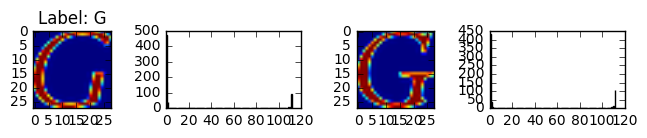

In [111]:
draw_images('G', valid_dataset[13], test_dataset[356])

In [112]:
manhattan_distance(valid_dataset[13], test_dataset[356])

89.980392

In [4]:
from ipyparallel import require
bins_size = 28 * 4
@require('numpy as np')
def calc_item_histogram(item, bins = bins_size):
    hist = np.histogram(item, bins=bins)
    return hist[0]

In [144]:
from ipyparallel import require
def count_equal_tuples(tuple_lst_A, tuple_lst_B, distance_threshold=0, min_distance_threshold = 0):
    counters = {}
    for item_A in tuple_lst_A:
        for item_B in tuple_lst_B:
            if item_A[lbl_idx] == item_B[lbl_idx]:
                if distance_threshold == 0 and is_equal_comparison(item_A[data_idx], item_B[data_idx]):
                    count_duplication(counters, item_A[lbl_idx], item_A[idx_idx], item_B[idx_idx])
                if distance_threshold > 0 and distance_threshold >= manhattan_distance(item_A[data_idx], item_B[data_idx]) > min_distance_threshold:
                    count_duplication(counters, item_A[lbl_idx], item_A[idx_idx], item_B[idx_idx])
    return counters

map_dict = {'0': 'A', '1': 'B', '2': 'C', '3': 'D', '4': 'E', '5': 'F', '6': 'G', '7': 'H', '8': 'I', '9': 'J', }

def get_char_by_lbl(lbl):
    result = map_dict[str(lbl)]
    return result

@require(get_char_by_lbl)
def count_duplication(counters, lbl, idxA, idxB):
    str_lbl = get_char_by_lbl(lbl)
    if str_lbl not in counters:
        counters[str_lbl] = {}
        counters[str_lbl]['counter'] = 0
    counters[str_lbl]['counter'] += 1
    if str(idxA) not in counters[str_lbl]:
        counters[str_lbl][str(idxA)] = []
    counters[str_lbl][str(idxA)].append(idxB)

@require(is_equal_comparison, count_duplication, manhattan_distance)
def item_acync_handler():
    idx_idx = 0
    lbl_idx = 1
    data_idx = 2
    for item_A in tuple_lst_A:
        for item_B in tuple_lst_B:
            if item_A[lbl_idx] == item_B[lbl_idx]:
                if distance_threshold == 0 and is_equal_comparison(item_A[data_idx], item_B[data_idx]):
                    count_duplication(counters, item_A[lbl_idx], item_A[idx_idx], item_B[idx_idx])
                if distance_threshold > 0 and distance_threshold >= manhattan_distance(item_A[data_idx], item_B[data_idx]) > min_distance_threshold:
                    count_duplication(counters, item_A[lbl_idx], item_A[idx_idx], item_B[idx_idx])
                
def reduce_counters(counters_lst):
    result = {}
    for counters in counters_lst:
        for letter_key, item in counters.items():
            if letter_key not in result:
                result[letter_key] = {'counter': 0}
            for key, value in item.items():
                if key == 'counter':
                    result[letter_key][key] += value
                elif key not in result[letter_key]:
                    result[letter_key][key] = value
                else:
                    for idx in value:
                        result[letter_key][key].append(idx)
    return result
    
    

In [152]:
from ipyparallel import Client
start_time = time.clock()
rc = Client()
dview = rc[:]
# lview = rc.load_balanced_view()
# lview.block = True
dview.push(dict(tuple_lst_B = test_tuple_lst, map_dict=map_dict)) #['tuple_lst_B'] = test_tuple_lst
dview['distance_threshold'] = 0
dview['min_distance_threshold'] = 0
dview['counters'] = {}
dview.scatter('tuple_lst_A', valid_tuple_lst)
# lview.map(item_acync_handler, valid_tuple_lst)
# lview.apply(item_acync_handler)
dview.block=True
dview.apply(item_acync_handler)
overlap_valid_test = reduce_counters(dview['counters'])
end_time = time.clock()
duration = timedelta(seconds=end_time - start_time)
print('Counting overlapping between validation and test datasets in', duration)
display_overlap(overlap_valid_test)

Counting overlapping between validation and test datasets in 0:00:19.987859
Label A: 5
Label B: 7
Label C: 10
Label D: 9
Label E: 11
Label F: 3
Label G: 11
Label H: 6
Label I: 8
Label J: 8
Total: 78


In [138]:
start_time = time.clock()
overlap_valid_test = count_equal_tuples(valid_tuple_lst, test_tuple_lst)
end_time = time.clock()
duration = timedelta(seconds=end_time - start_time)
print('Counting overlapping between validation and test datasets in', duration)
display_overlap(overlap_valid_test)

Counting overlapping between validation and test datasets in 0:01:09.171534
Label A: 5
Label B: 7
Label C: 10
Label D: 9
Label E: 11
Label F: 3
Label G: 11
Label H: 6
Label I: 8
Label J: 8
Total: 78


In [7]:
from ipyparallel import Client
rc = Client()
dview = rc[:]

In [19]:
start_time = time.clock()
serial_result = list(map(calc_item_histogram, train_dataset))
end_time = time.clock()
print(timedelta(seconds=end_time - start_time))
serial_result[0]

0:00:24.122032


array([224,  24,   7,  10,   5,   4,   4,   9,  11,   3,   6,   6,   2,
         6,  12,   4,   4,   4,   6,   8,   8,  10,   8,   6,   5,   8,
         4,   2,   6,   7,   9,   5,   8,   5,   7,   2,  12,   5,   2,
         4,   5,   5,   6,  10,   5,   4,   8,   2,   4,   1,   1,   4,
         2,   4,   8,   2,   1,   5,   1,   1,   4,   4,   6,   0,   3,
         4,   3,   1,   2,   2,   3,   1,   1,   3,   0,   3,   1,   0,
         2,   4,   5,   1,   0,   2,   0,   0,   2,   3,   2,   1,   3,
         0,   2,   4,   0,   1,   2,   0,   0,   1,   1,   4,   1,   2,
         0,   2,   4,   0,   1,   1,  18, 113], dtype=int64)

In [22]:
start_time = time.clock()
async_obj = dview.map(calc_item_histogram, train_dataset)
res = async_obj.get()
end_time = time.clock()
print(timedelta(seconds=end_time - start_time))
res[0]

0:00:09.314704


array([224,  24,   7,  10,   5,   4,   4,   9,  11,   3,   6,   6,   2,
         6,  12,   4,   4,   4,   6,   8,   8,  10,   8,   6,   5,   8,
         4,   2,   6,   7,   9,   5,   8,   5,   7,   2,  12,   5,   2,
         4,   5,   5,   6,  10,   5,   4,   8,   2,   4,   1,   1,   4,
         2,   4,   8,   2,   1,   5,   1,   1,   4,   4,   6,   0,   3,
         4,   3,   1,   2,   2,   3,   1,   1,   3,   0,   3,   1,   0,
         2,   4,   5,   1,   0,   2,   0,   0,   2,   3,   2,   1,   3,
         0,   2,   4,   0,   1,   2,   0,   0,   1,   1,   4,   1,   2,
         0,   2,   4,   0,   1,   1,  18, 113], dtype=int64)

In [23]:
manhattan_distance(serial_result[0], res[0])

0

In [33]:
item_a = valid_dataset[8]
item_b = valid_dataset[9]
print(item_a.shape, item_b.shape)
print(manhattan_distance(item_a, item_b))
print(distance.cityblock(item_a.flatten(), item_b.flatten()))

(28, 28) (28, 28)
291.098
291.098


In [34]:
%timeit manhattan_distance(item_a, item_b)

The slowest run took 13.99 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 7.75 µs per loop


In [36]:
%timeit is_equal_comparison(item_a, item_b)

The slowest run took 16.80 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 4.99 µs per loop


In [37]:
%timeit manhattan_distance(valid_histogram[8], valid_histogram[9])

The slowest run took 7.53 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 5.46 µs per loop


In [38]:
%timeit distance.cityblock(item_a.flatten(), item_b.flatten())

The slowest run took 13.14 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 16.4 µs per loop


In [32]:
lst = [(1, 'A'), (2, 'B'), (3, 'C')]

NameError: name 'lview' is not defined

In [22]:
res = f.map(range(32))

In [24]:
res

<AsyncMapResult: f:finished>

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---